#### In this notebook we download single day MUR data (netcdf) to a folder, then import that data, convert it to an xarray and then apply the 3 algorithms (Canny, BOA and CCA). We can also visualize the fronts in a map or save the 3 fronts and the sst image in a NetCDF file

## Import libraries

In [1]:
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from pathlib import Path
%matplotlib inline
from PIL import Image
from math import floor, ceil
import cv2
from PIL import Image
import pandas as pd
import wget
import datetime
from datetime import date, timedelta
from matplotlib.colors import ListedColormap
from pydap.client import open_url
import netCDF4 as nc
from scipy.ndimage import gaussian_filter

from global_land_mask import globe

plt.rcParams["figure.figsize"] = 12, 8

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Import functions to apply the BOA and CCA, which are defined in other notebooks

In [2]:
#import functions to aplly the CCA
from ipynb.fs.full.CCA_functions_xarray import getFrontInWindow
from ipynb.fs.full.CCA_functions_xarray import CCA_SIED

In [3]:
#import functions to aplly the BOA
from ipynb.fs.full.BOA_functions import boa

## ------------------------------ Functions to Download MUR Data  (NEW) ------------------------------------

### OPeNDAP Access
#### Notebook Objectives:
* Search the common metadata repository (CMR) for the MUR dataset
* Obtain OPeNDAP links from CMR search
* Download data from OPeNDAP links and open via xarray to visualize data

In [4]:
#https://ghrc.nsstc.nasa.gov/opendap/globalir/data/2020/0525/globir.20146.0000
from netCDF4 import Dataset
import xarray as xr
import dask
import os
import requests

#Allows us to visualize the dask progress for parallel operations
from dask.diagnostics import ProgressBar
ProgressBar().register()


### Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

You will also need a netrc file containing your NASA Earthdata Login credentials in order to execute this notebook. A netrc file can be created manually within text editor and saved to your home directory. For additional information see: Authentication for NASA Earthdata

In this notebook, we will be calling the authentication in the below cell, a work around if you do not yet have a netrc file.

### Authentication for NASA Earthdata

This notebook creates a hidden .netrc file (_netrc for Window OS) with Earthdata login credentials in your home directory. This file is needed to access NASA Earthdata assets from a scripting environment like Python.


In [5]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os

In [6]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

# Determine the OS (Windows machines usually use an '_netrc' file)
netrc_name = "_netrc" if system()=="Windows" else ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

    # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
except TypeError:
    homeDir = os.path.expanduser("~")
    Popen('echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)

In [ ]:
#The .netrc file with my credentials was created in the home directory

In [7]:
import urllib
from urllib import request, parse
from http.cookiejar import CookieJar
import json
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file
    first and if no credentials are found, it prompts for them.
    Valid endpoints include:
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
        
        print(username)
        print(_)
        print(password)
        
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

edl="urs.earthdata.nasa.gov"

setup_earthdata_login_auth(edl)

lfigueiredo1
None
NicolauCOLAB1997


In [ ]:
# Please provide your Earthdata Login credentials to allow data access
# Your credentials will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter

In [8]:
def request_data(date_str):
    
    """
    Function to request the MUR data. date_str is a string in the format: %Y-%m-%d
    The data will be downloaded to the MUR_daily_data folder which is inside the data folder
    We return the basename to know which netcdf file we just donwloaded to the MUR_daily_data folder
    """
    date_string = date_str + 'T09:00:00Z'
    
    url = 'https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1996881146-POCLOUD&temporal=' + date_string + ',' + date_string + '&pageSize=365'
    
    #CMR Link to use
    #https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id=C1625128926-GHRC_CLOUD&temporal=2019-01-01T10:00:00Z,2019-12-31T23:59:59Z
    r = requests.get(url)
    response_body = r.json()
    
    
    od_files = []
    for itm in response_body['items']:
        for urls in itm['umm']['RelatedUrls']:
            if 'OPeNDAP' in urls['Description']:
                od_files.append(urls['URL'])

    print(od_files)
    
    
    base_path = os.getcwd()
    base_path = os.path.join(base_path, '../data')


    exist_path = os.path.exists(os.path.join(base_path, 'MUR_daily_data'))   #check if folder MUR_daily_data exists in data folder
    if not exist_path:                                                            #if it don't exist:
        os.makedirs(os.path.join(base_path, 'MUR_daily_data'))  


    for f in od_files:
        print (" opening " + f)
        data_url = f'{f}.dap.nc4'

        # The notation below is [start index, step, end index]
        # lat[ /lat= 0..17998] start index. = -90
        # lon[ /lon= 0..35999] start index. = -180
        # time[ /time= 0..0] 

        required_variables = {'analysed_sst[0:1:0][12499:1:13499][16099:1:17499]',
                              'lat[12499:1:13499]',     # [35, 45]
                              'lon[16099:1:17499]',     # [-19, -5]
                              'time[0:1:0]'}

        basename = os.path.basename(data_url)
        request_params = {'dap4.ce': ';'.join(required_variables)}
        #identity encoding to work around an issue with server side response compression (??)
        response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

        basename = os.path.join('../data/MUR_daily_data', basename)

        if response.ok:
            with open(basename, 'wb') as file_handler:
                file_handler.write(response.content)
        else:
            print(f'Request failed: {response.text}')
            
        return basename

In [9]:
nc_name = request_data(date_str="2023-05-08")

['https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230508090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1']
 opening https://opendap.earthdata.nasa.gov/collections/C1996881146-POCLOUD/granules/20230508090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1


In [10]:
nc_name

'../data/MUR_daily_data/20230508090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.dap.nc4'

In [13]:
def get_data(nc_name):
    
    """
    Function to get our netCDF file that is stored in the MUR_daily_data folder
    and convert it to an xarray. The nc_name parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    file_path = os.path.join(base_path, nc_name)  
    
    xarray_mur = xr.open_mfdataset(file_path, engine='netcdf4')
    
    #convert temperature from Kelvin to Celsius
    xarray_mur['analysed_sst'] = xarray_mur['analysed_sst'] - 273.15
    
    return xarray_mur

In [14]:
xarray_mur = get_data(nc_name)

In [15]:
xarray_mur

<xarray.Dataset>
Dimensions:       (lat: 1001, lon: 1401, time: 1)
Coordinates:
  * lon           (lon) float32 -19.0 -18.99 -18.98 -18.97 ... -5.02 -5.01 -5.0
  * time          (time) datetime64[ns] 2023-05-07T09:00:00
  * lat           (lat) float32 35.0 35.01 35.02 35.03 ... 44.98 44.99 45.0
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1001, 1401), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.7
    title:                               Daily MUR SST, Interim near-real-tim...
    summary:                             A merged, multi-sensor L4 Foundation...
    references:                          http://podaac.jpl.nasa.gov/Multi-sca...
    institution:                         Jet Propulsion Laboratory
    history:                             near real time (nrt) version created...
    ...                                  ...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-184
    build_dmrpp_metadata.bes:            3.20.13-184
    build_dmrpp_metadata.libdap:         libdap-3.20.11-59
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_wDto -f...
    history_json:                        [{"$schema":"https:\/\/harmony.earth...

## ---------------------------------------------------------------------------------------------------------------------------

#### Function to visualize the front in a map

In [16]:
def front_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map of the front.
    We use the sst data "analysed_sst" to create a mask for the continental zone
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    # replace NaNs with 0s
    fp = np.nan_to_num(fp, nan=0)
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    sst = data_xarray['analysed_sst'].values[0]
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("Front (MUR) ", fontsize=20)

## -------------------------------------------- Canny Algorithm ------------------------------------------------

In [17]:

def canny_front_detection_1day(data_xarray, thresh_min=120, thresh_max=220, apertureSize=5, sigma=5):
    
    """
    This function receives an xarray with MUR data for a individual day and returns the array 
    that result from the aplication of the Canny Algorithm from OpenCV. 
    One can change the minimum and maximum threshold, the apertureSize.
    One can also apply a gaussian filter with a certain sigma value to reduce noise of the image.
    """
    
    #Get the sst array in the right shape
    sst = data_xarray['analysed_sst'][0,:,:].values
    #Convert Temperature values to uint8 format with values in the range of 0-255
    sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
    sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    #in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
    sst_final = gaussian_filter(sst_final, sigma=sigma)   
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(sst_final, thresh_min, thresh_max, apertureSize=apertureSize, L2gradient=False)
    
    canny[canny == 255] = 1
    
    #convert 0s to Nans
    canny = canny.astype('float')
    canny[canny == 0] = 'nan'
    
    canny_front = np.flipud(canny)   
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    # Lat/lon points to get
    lat = np.linspace(lat_min,lat_max,lat_dims)
    lon = np.linspace(lon_min,lon_max,lon_dims)
    # Make a grid
    lon_grid, lat_grid = np.meshgrid(lon,lat)
    # Get whether the points are on land.
    z = globe.is_land(lat_grid, lon_grid)
    canny_front[z == True] = np.nan
    
    
    return canny_front

In [18]:
canny_f = canny_front_detection_1day(xarray_mur)

[########################################] | 100% Completed |  0.1s


###                                                Canny Algorithm

[########################################] | 100% Completed |  0.1s


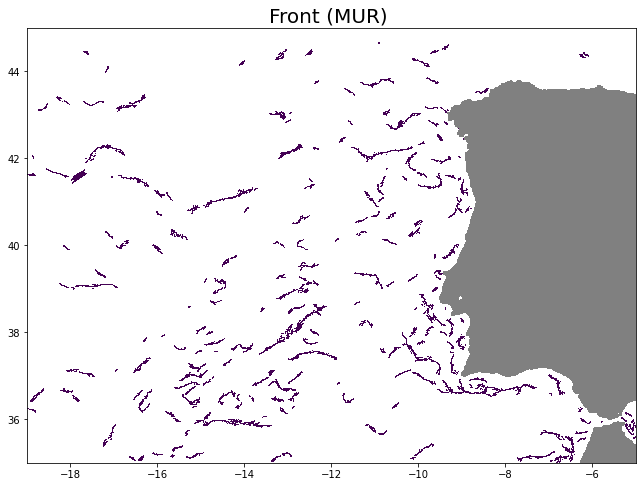

In [19]:
front_visualization(canny_f, xarray_mur)

## -------------------------------- Belkin O'Reilly Algorithm (BOA) -----------------------------------------

In [20]:

def BOA_aplication(data_xarray, threshold = 0.05):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lon = np.array(data_xarray['lon']).astype('float64')
    lat = np.array(data_xarray['lat']).astype('float64')
    
    ingrid = data_xarray['analysed_sst'][0,:,:].values    
    
    boa_front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    boa_front = np.flip(boa_front, axis=0)
    boa_front = np.array([[boa_front[j][i] for j in range(len(boa_front))] for i in range(len(boa_front[0])-1,-1,-1)])
    
    boa_front = np.where(boa_front>=threshold, 1, boa_front)    
    boa_front = np.where(boa_front<threshold, 0, boa_front)
    
    #convert 0s to Nans
    boa_front[boa_front == 0] = 'nan'
    
    boa_front = np.flipud(boa_front) 

    return boa_front


In [21]:
boa_f = BOA_aplication(xarray_mur, threshold=0.05)

[########################################] | 100% Completed |  0.1s


###                                               Belkin O'Reilly Algorithm

[########################################] | 100% Completed |  0.1s


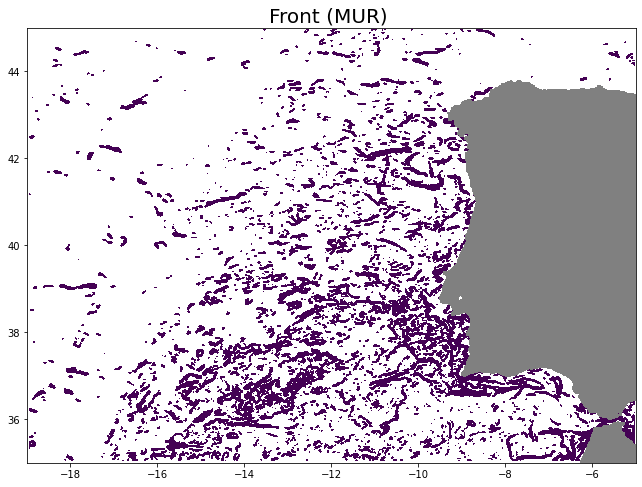

In [22]:
front_visualization(boa_f, xarray_mur)

## ---------------------------------- Cayula-Cornillon Algorithm (CCA) ------------------------------------

In [23]:
    
def CCA_front(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    """
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    div_rows = (lat_max-lat_min)/lat_dims
    div_cols = (lon_max-lon_min)/lon_dims
    
    
    front = np.zeros((lat_dims,lon_dims))       #initialize a matrix of zeros. This shape is for the MUR data
    
    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (-lon_min+value)/div_cols                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (lat_max-value)/div_rows                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
    front[front != 0] = 1
    
    #convert 0s to Nans
    front[front == 0] = 'nan'

    cca_front = np.flipud(front) 
    
    
    return cca_front

[########################################] | 100% Completed |  0.1s


/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:79: RuntimeWarning: invalid value encountered in double_scalars
  "    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise\n",
/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:177: UserWarning: No contour levels were found within the data range.
  "                if (w[row, col+1] <= thresValue):               #if right pixel < separation\n",


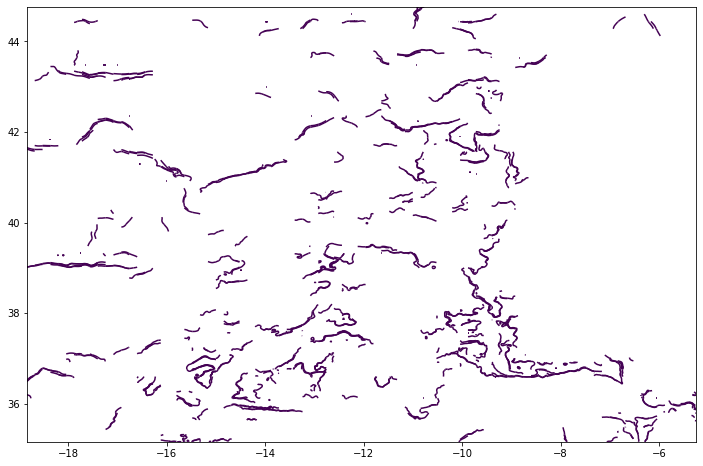

In [24]:
cca_f = CCA_front(xarray_mur)

###                                                Cayula-Cornillon Algorithm

[########################################] | 100% Completed |  0.1s


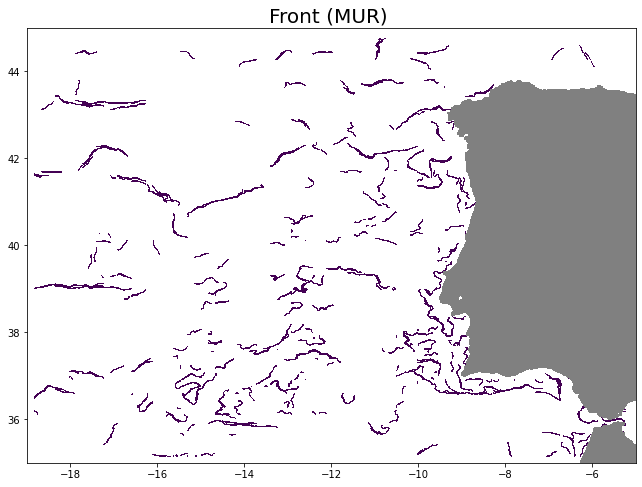

In [25]:
front_visualization(cca_f, xarray_mur)

## -------------------------------------------- Real SST Image --------------------------------------------------

In [26]:
def real_sst_image(data_xarray):
        
    """
    Function to return the real sst image as an array
    """
    
    sst_image = data_xarray['analysed_sst'][0,:,:].values
    
    return sst_image

In [27]:
sst_image = real_sst_image(xarray_mur)

[########################################] | 100% Completed |  0.1s


In [28]:
def sst_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map the SST data.
    We use the sst data "analysed_sst" to create a mask for the continental zone.
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    sst = data_xarray['analysed_sst'].values[0]
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap='viridis', extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("SST (MUR) ", fontsize=20)

[########################################] | 100% Completed |  0.1s


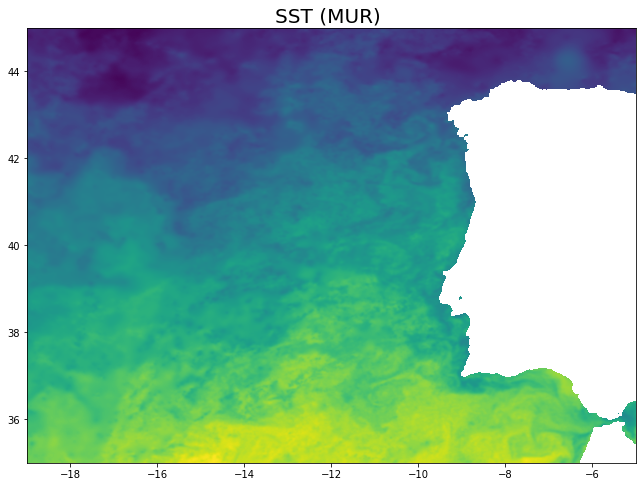

In [29]:
sst_visualization(sst_image, xarray_mur)

## -------------------------------------- Save results in NetCDF ---------------------------------------------

In [36]:
day_txt = '20221225'

In [37]:

base_path = os.getcwd()
base_path = os.path.join(base_path, '../data')

#Check if exists a folder to save the netcdf. If not create the folder
exist_path = os.path.exists(os.path.join(base_path, 'MUR_daily_fronts_netcdf'))    
if not exist_path:                                                                         
    os.makedirs(os.path.join(base_path, 'MUR_daily_fronts_netcdf'))                


In [38]:

def fronts_2_netcdf(data_xarray, day_txt, sst_image, canny_f, boa_f, cca_f):
    
    """
    File to save the 4 arrays (canny, BOA, CCA, SST) as NetCDFs. This arrays are regarding a specific day so we
    don't need to have a time variable (either way it can be add this variable if one pleases)
    day_txt is a string in the format Y%m%d
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    nc_file = os.getcwd()
    nc_file = os.path.join(nc_file, '../data/MUR_daily_fronts_netcdf/MUR_' + day_txt + '.nc')

    ds = nc.Dataset(nc_file, 'w', format='NETCDF4')

    ds.title = 'MUR ' + day_txt + ' Fronts Arrays (Xarrays)'

    #create dimensions of the NetCDF file
    lat = ds.createDimension('lat', lat_dims)
    lon = ds.createDimension('lon', lon_dims)

    lats = ds.createVariable('lat', 'f4', ('lat', ))
    lons = ds.createVariable('lon', 'f4', ('lon', ))

    sst_analyzed = ds.createVariable('sst', 'f4', ('lat', 'lon',))    #('time', 'lat', 'lon',)
    sst_analyzed.units = 'C'   #degrees Celsius
    sst_analyzed.description = 'Array with the Sea-Surface Temperature (SST) relative to the MUR data for that day'
    sst_analyzed[:, :] = sst_image


    canny = ds.createVariable('Canny', 'f4', ('lat', 'lon',))
    canny.units = 'Unknown'
    canny.description = 'Binary Array with identyfied fronts through Canny from OpenCV (1-> front), (0->not front)'
    canny[:, :] = canny_f.astype(float)

    boa = ds.createVariable('BOA', 'f4', ('lat', 'lon',))
    boa.units = 'Unknown'
    boa.description = 'Binary Array with identyfied fronts through the Belkin O Reilly Algorithm (temperature gradient). If the gradient is bigger than certain threshold is considered front (1) otherwise 0'
    boa[:, :] = boa_f

    cca = ds.createVariable('CCA', 'f4', ('lat', 'lon',))
    cca.units = 'Unknown'
    cca.description = 'Binary Array with identyfied fronts through the Cayula Cornillon Algorithm (1->front) (0->not front)'
    cca[:, :] = cca_f.astype(float)


    lats[:] = np.linspace(lat_min, lat_max, lat_dims)
    lons[:] = np.linspace(lon_min, lon_max, lon_dims)

    ds.close()



In [39]:
fronts_2_netcdf(xarray_mur, '20221225', sst_image, canny_f, boa_f, cca_f )